# MNIST Addition

This notebook shows an implementation of [MNIST Addition](https://arxiv.org/abs/1805.10872). In this task, pairs of MNIST handwritten images and their sums are given, alongwith a domain knowledge base which contain information on how to perform addition operations. Our objective is to input a pair of handwritten images and accurately determine their sum.

Intuitively, we first use a machine learning model (learning part) to convert the input images to digits (we call them pseudo labels), and then use the knowledge base (reasoning part) to calculate the sum of these digits. Since we do not have ground-truth of the digits, the reasoning part will leverage domain knowledge and revise the initial digits yielded by the learning part into results derived from abductive reasoning. This process enables us to further refine and retrain the machine learning model.

In [1]:
# Import necessary libraries and modules
import os.path as osp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from examples.mnist_add.datasets import get_dataset
from examples.models.nn import LeNet5
from abl.learning import ABLModel, BasicNN
from abl.reasoning import KBBase, Reasoner
from abl.evaluation import ReasoningMetric, SymbolMetric
from abl.utils import ABLLogger, print_log
from abl.bridge import SimpleBridge

## Working with Data

First, we get the training and testing datasets:

In [2]:
train_data = get_dataset(train=True, get_pseudo_label=True)
test_data = get_dataset(train=False, get_pseudo_label=True)

Both datasets contain several data examples. In each data example, we have three components: X (a pair of images), gt_pseudo_label (a pair of corresponding ground truth digits, i.e., pseudo labels), and Y (their sum). The datasets are illustrated as follows. 

There are 30000 data examples in the training set and 5000 data examples in the test set
As an illustration, in the first data example of the training set, we have:
X (2 images):


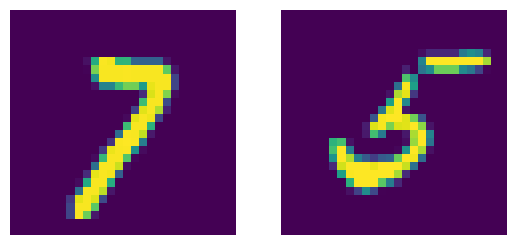

gt_pseudo_label (2 ground truth pseudo label): 7, 5
Y (their sum result): 12


In [15]:
print(f"There are {len(train_data[0])} data examples in the training set and {len(test_data[0])} data examples in the test set")
print("As an illustration, in the first data example of the training set, we have:")
print(f"X ({len(train_data[0][0])} images):")
plt.subplot(1,2,1)
plt.axis('off') 
plt.imshow(train_data[0][0][0].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.axis('off') 
plt.imshow(train_data[0][0][1].numpy().transpose(1, 2, 0))
plt.show()
print(f"gt_pseudo_label ({len(train_data[1][0])} ground truth pseudo label): {train_data[1][0][0]}, {train_data[1][0][1]}")
print(f"Y (their sum result): {train_data[2][0]}")

## Building the Learning Part

To build the learning part, we need to first build a base machine learning model. We use a simple [LeNet-5 neural network](https://en.wikipedia.org/wiki/LeNet) to complete this task, and encapsulate it within a `BasicNN` object to create the base model. `BasicNN` is a class that encapsulates a PyTorch model, transforming it into a base model with an sklearn-style interface. 

In [16]:
cls = LeNet5(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cls.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

base_model = BasicNN(
    cls,
    loss_fn,
    optimizer,
    device,
    batch_size=32,
    num_epochs=1,
)

`BasicNN` offers methods like `predict` and `predict_prob`, which are used to predict the outcome class index and the probabilities for an image, respectively. As shown below:

In [17]:
pred_idx = base_model.predict(X=[torch.randn(1, 28, 28).to(device) for _ in range(32)])
print(f"Shape of pred_idx for a batch of 32 examples: {pred_idx.shape}")
pred_prob = base_model.predict_proba(X=[torch.randn(1, 28, 28).to(device) for _ in range(32)])
print(f"Shape of pred_prob for a batch of 32 examples: {pred_prob.shape}")

Shape of pred_idx for a batch of 32 samples: (32,)
Shape of pred_prob for a batch of 32 samples: (32, 10)


However, base model built above are trained to make predictions on instance-level data, i.e., a single image, and can not directly utilize example-level data, i.e., a pair of images. Therefore, we then wrap the base model into `ABLModel` which enables the learning part to train, test, and predict on example-level data.

In [18]:
model = ABLModel(base_model)

TODO: 示例展示ablmodel和base model的predict的不同

In [19]:
# from abl.structures import ListData
# data_examples = ListData()
# data_examples.X = [list(torch.randn(2, 1, 28, 28)) for _ in range(3)]

# model.predict(data_examples)

## Building the Reasoning Part

In the reasoning part, we first build a knowledge base which contain information on how to perform addition operations. We build it by creating a subclass of `KBBase`. In the derived subclass, we have to first initialize the `pseudo_label_list` parameter specifying list of possible pseudo labels, and then override the `logic_forward` function defining how to perform (deductive) reasoning.

In [20]:
class AddKB(KBBase):
    def __init__(self, pseudo_label_list=list(range(10))):
        super().__init__(pseudo_label_list)

    # Implement the deduction function
    def logic_forward(self, nums):
        return sum(nums)

kb = AddKB()

The knowledge base can perform logical reasoning. Below is an example of performing (deductive) reasoning: # TODO: ABDUCTIVE REASONING

In [21]:
pseudo_label_example = [1, 2]
reasoning_result = kb.logic_forward(pseudo_label_example)
print(f"Reasoning result of pseudo label example {pseudo_label_example} is {reasoning_result}.")

Reasoning result of pseudo label sample [1, 2] is 3.


Note: In addition to building a knowledge base based on `KBBase`, we can also establish a knowledge base with a ground KB using `GroundKB`, or a knowledge base implemented based on Prolog files using `PrologKB`. The corresponding code for these implementations can be found in the `main.py` file. Those interested are encouraged to examine it for further insights.

Then, we create a reasoner by instantiating the class ``Reasoner``. Due to the indeterminism of abductive reasoning, there could be multiple candidates compatible to the knowledge base. When this happens, reasoner can minimize inconsistencies between the knowledge base and pseudo labels predicted by the learning part, and then return only one candidate which has highest consistency.

In [22]:
reasoner = Reasoner(kb)

Note: During creating reasoner, the definition of "consistency" can be customized within the `dist_func` parameter. In the code above, we employ a consistency measurement based on confidence, which calculates the consistency between the data example and candidates based on the confidence derived from the predicted probability. In `main.py`, we provide options for utilizing other forms of consistency measurement.

Also, during process of inconsistency minimization, one can leverage [ZOOpt library](https://github.com/polixir/ZOOpt) for acceleration. Options for this are also available in `main.py`. Those interested are encouraged to explore these features.

## Building Evaluation Metrics

Next, we set up evaluation metrics. These metrics will be used to evaluate the model performance during training and testing. Specifically, we use `SymbolMetric` and `ReasoningMetric`, which are used to evaluate the accuracy of the machine learning model’s predictions and the accuracy of the final reasoning results, respectively.

In [23]:
metric_list = [SymbolMetric(prefix="mnist_add"), ReasoningMetric(kb=kb, prefix="mnist_add")]

## Bridge Learning and Reasoning

Now, the last step is to bridge the learning and reasoning part. We proceed this step by creating an instance of `SimpleBridge`.

In [24]:
bridge = SimpleBridge(model, reasoner, metric_list)

Perform training and testing by invoking the `train` and `test` methods of `SimpleBridge`.

In [25]:
# Build logger
print_log("Abductive Learning on the MNIST Addition example.", logger="current")
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.train(train_data, loops=5, segment_size=1/3, save_interval=1, save_dir=weights_dir)
bridge.test(test_data)

12/19 14:41:46 - abl - INFO - Abductive Learning on the MNIST Addition example.
12/19 14:41:46 - abl - INFO - loop(train) [1/5] segment(train) [1/3] 
12/19 14:41:51 - abl - INFO - model loss: 1.81279
12/19 14:41:51 - abl - INFO - loop(train) [1/5] segment(train) [2/3] 
12/19 14:41:56 - abl - INFO - model loss: 1.40474
12/19 14:41:56 - abl - INFO - loop(train) [1/5] segment(train) [3/3] 
12/19 14:42:01 - abl - INFO - model loss: 1.17817
12/19 14:42:01 - abl - INFO - Evaluation start: loop(val) [1]
12/19 14:42:02 - abl - INFO - Evaluation ended, mnist_add/character_accuracy: 0.496 mnist_add/reasoning_accuracy: 0.336 
12/19 14:42:02 - abl - INFO - Saving model: loop(save) [1]
12/19 14:42:02 - abl - INFO - Checkpoints will be saved to results/20231219_14_41_46/weights/model_checkpoint_loop_1.pth
12/19 14:42:02 - abl - INFO - loop(train) [2/5] segment(train) [1/3] 
12/19 14:42:07 - abl - INFO - model loss: 0.85932
12/19 14:42:07 - abl - INFO - loop(train) [2/5] segment(train) [2/3] 
12/19 1